In [1]:
import open3d as o3d
import glob
from pydicom import dcmread
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from rsna_dataloader import *

DATA_BASEPATH = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
TRAINING_DATA = retrieve_coordinate_training_data(DATA_BASEPATH)

df = TRAINING_DATA.dropna()
# This drops any subjects with nans

filtered_df = pd.DataFrame(columns=df.columns)
for series_desc in CONDITIONS.keys():
    subset = df[df['series_description'] == series_desc]
    if series_desc == "Sagittal T2/STIR":
        subset = subset[subset.groupby(["study_id"]).transform('size') == 5]
    else:
        subset = subset[subset.groupby(["study_id"]).transform('size') == 10]
    filtered_df = pd.concat([filtered_df, subset])

filtered_df = filtered_df[filtered_df.groupby(["study_id"]).transform('size') == 25]

series_descs = {e[0]: e[1] for e in df[["series_id", "series_description"]].drop_duplicates().values}

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [3]:
coords = pd.read_csv("../data/lumbar-coordinate-pretraining-dataset/coords_3d.csv")
coords

,study_id,level,x,y,z
0,4003253,L1/L2,2.281485,74.681099,-389.679551
1,4003253,L2/L3,2.503593,73.621785,-421.436447
2,4003253,L3/L4,2.750310,74.774676,-457.109285
3,4003253,L4/L5,2.924442,80.522574,-483.128617
4,4003253,L5/S1,3.098990,89.018362,-509.676647
...,...,...,...,...,...
9865,4290709089,L1/L2,10.407222,74.543790,-347.122554
9866,4290709089,L2/L3,9.814853,64.679538,-380.458776
9867,4290709089,L3/L4,9.187656,61.836557,-413.573176
9868,4290709089,L4/L5,8.589401,67.148507,-442.856477


In [4]:
bounding_boxes = pd.read_csv("../data/SpineNet/bounding_boxes_3d.csv")
bounding_boxes

,study_id,level,x_min,y_min,z_min,x_max,y_max,z_max
0,4003253,l1_L2,-45.851279,39.930603,-407.439583,50.460643,121.311514,-372.440063
1,4003253,l2_L3,-42.344061,38.789830,-442.812581,47.424769,115.405745,-404.206728
2,4003253,l3_L4,-44.070553,38.111370,-476.169148,49.634533,116.964831,-440.144351
3,4003253,l4_L5,-50.819013,39.289729,-515.230110,52.021650,125.861746,-465.939080
4,4003253,l5_S1,-51.993413,50.336502,-552.849805,48.766461,138.182300,-486.507758
...,...,...,...,...,...,...,...,...
9670,4290709089,l1_L2,-39.807054,34.636994,-367.061554,42.649795,110.534076,-317.275463
9671,4290709089,l2_L3,-53.479927,22.737605,-401.873208,55.072514,117.923031,-352.044886
9672,4290709089,l3_L4,-51.382277,22.810999,-430.469909,51.648787,108.310651,-393.989755
9673,4290709089,l4_L5,-50.165922,23.741940,-470.895005,49.034001,111.050317,-423.723655


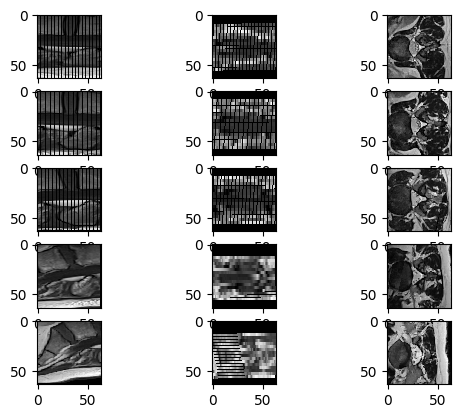

In [5]:
f, axs = plt.subplots(5, 3)

for i in range(5):
    row = bounding_boxes.iloc[i]
    level = row['level'].replace("/", "").lower()
    min_bound = np.array([row['x_min'], row['y_min'], row['z_min']])
    max_bound = np.array([row['x_max'], row['y_max'], row['z_max']])
    
    grid = read_vertebral_level_as_voxel_grid(
        f"../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/{row['study_id']}",
        vertebral_level=level,
        min_bound=min_bound,
        max_bound=max_bound,
        series_type_dict=series_descs,
        voxel_size=(64, 64, 64),
        caching=False)
    
    # grid = tf(grid.astype(np.float32))
    
    axs[i - 5, 0].imshow(np.max(grid[0, 31:33], axis=0), cmap="gray")
    axs[i - 5, 1].imshow(np.max(grid[0, :, 31:33], axis=1), cmap="gray")
    axs[i - 5, 2].imshow(np.max(grid[1, :, :, 31:33], axis=2), cmap="gray")
    
plt.show()

In [6]:
def read_study_as_pcd(dir_path,
                      series_types_dict=None,
                      downsampling_factor=1,
                      resize_slices=True,
                      resize_method="nearest",
                      stack_slices_thickness=True,
                      img_size=(256, 256)):
    pcd_overall = o3d.geometry.PointCloud()

    for path in glob.glob(os.path.join(dir_path, "**/*.dcm"), recursive=True):
        dicom_slice = dcmread(path)

        series_id = os.path.basename(os.path.dirname(path))
        study_id = os.path.basename(os.path.dirname(os.path.dirname(path)))
        if series_types_dict is None or int(series_id) not in series_types_dict:
            series_desc = dicom_slice.SeriesDescription
        else:
            series_desc = series_types_dict[int(series_id)]
            series_desc = series_desc.split(" ")[-1]

        x_orig, y_orig = dicom_slice.pixel_array.shape
        if resize_slices:
            if resize_method == "nearest":
                img = np.expand_dims(cv2.resize(dicom_slice.pixel_array, img_size, interpolation=cv2.INTER_AREA), -1)
            elif resize_method == "maxpool":
                img_tensor = torch.tensor(dicom_slice.pixel_array).float()
                img = F.adaptive_max_pool2d(img_tensor.unsqueeze(0), img_size).numpy()
            else:
                raise ValueError(f"Invalid resize_method {resize_method}")
        else:
            img = np.expand_dims(np.array(dicom_slice.pixel_array), -1)
        x, y, z = np.where(img)

        downsampling_factor_iter = max(downsampling_factor, int(math.ceil(len(x) / 6e6)))

        index_voxel = np.vstack((x, y, z))[:, ::downsampling_factor_iter]
        grid_index_array = index_voxel.T
        pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(grid_index_array.astype(np.float64)))

        vals = np.expand_dims(img[x, y, z][::downsampling_factor_iter], -1)
        if series_desc == "T1":
            vals = np.pad(vals, ((0, 0), (0, 2)))
        elif series_desc == "T2":
            vals = np.pad(vals, ((0, 0), (1, 1)))
        elif series_desc == "T2/STIR":
            vals = np.pad(vals, ((0, 0), (2, 0)))
        else:
            raise ValueError(f"Unknown series desc: {series_desc}")

        pcd.colors = o3d.utility.Vector3dVector(vals.astype(np.float64))

        if resize_slices:
            transform_matrix_factor = np.matrix(
                [[0, y_orig / img_size[1], 0, 0],
                 [x_orig / img_size[0], 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]]
            )
        else:
            transform_matrix_factor = np.matrix(
                [[0, 1, 0, 0],
                 [1, 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]]
            )

        dX, dY = dicom_slice.PixelSpacing
        dZ = dicom_slice.SliceThickness

        X = np.array(list(dicom_slice.ImageOrientationPatient[:3]) + [0]) * dX
        Y = np.array(list(dicom_slice.ImageOrientationPatient[3:]) + [0]) * dY

        S = np.array(list(dicom_slice.ImagePositionPatient) + [1])

        transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
        transform_matrix = transform_matrix @ transform_matrix_factor

        if stack_slices_thickness:
            for z in range(int(dZ) + 1):
                pos = list(dicom_slice.ImagePositionPatient)
                if series_desc == "T2":
                    pos[-1] += z
                else:
                    pos[0] += z
                S = np.array(pos + [1])

                transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
                transform_matrix = transform_matrix @ transform_matrix_factor

                pcd_overall += copy.deepcopy(pcd).transform(transform_matrix)

        else:
            pcd_overall += copy.deepcopy(pcd).transform(transform_matrix)

    return pcd_overall


In [7]:
def read_vertebral_level_as_voxel_grid(dir_path,
                                       vertebral_level: str,
                                       max_bound: np.array,
                                       min_bound: np.array,
                                       pcd_overall: o3d.geometry.PointCloud = None,
                                       series_type_dict=None,
                                       downsampling_factor=1,
                                       voxel_size=(128, 128, 32),
                                       caching=True,
                                       ):
    cache_path = os.path.join(dir_path, f"cached_grid_{vertebral_level}_{voxel_size[0]}_{voxel_size[1]}_{voxel_size[2]}.npy.gz")
    f = None
    if caching and os.path.exists(cache_path):
        try:
            f = pgzip.PgzipFile(cache_path, "r")
            ret = np.load(f, allow_pickle=True)
            f.close()
            return ret
        except Exception as e:
            print(dir_path, "\n", e)
            if f:
                f.close()
            os.remove(cache_path)
    
    tf = tio.Resize(voxel_size)
    
    if pcd_overall is None:
        pcd_overall = read_study_as_pcd(dir_path,
                                        series_types_dict=series_type_dict,
                                        downsampling_factor=downsampling_factor,
                                        img_size=(voxel_size[0], voxel_size[1]),
                                        stack_slices_thickness=True,
                                        resize_slices=False)

    bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=min_bound, max_bound=max_bound)
    pcd_level = pcd_overall.crop(bbox)
        
    size = 1
    voxel_level = o3d.geometry.VoxelGrid().create_from_point_cloud(pcd_level, size, color_mode=o3d.geometry.VoxelGrid.VoxelColorMode.MAX)
        
    # bbox = pcd_level.get_axis_aligned_bounding_box()
    # 
    # max_b = np.array(bbox.get_max_bound())
    # min_b = np.array(bbox.get_min_bound())
    # 
    # pts = (np.array(pcd_level.points) - min_b) * (
    #         (voxel_size[0] - 1, voxel_size[1] - 1, voxel_size[2] - 1) / (max_b - min_b))
    # coords = np.round(pts).astype(np.int32)
    # vals = np.array(pcd_level.colors, dtype=np.float16)
    
    coords = []
    vals = []

    for voxel in voxel_level.get_voxels():
        coords.append(voxel.grid_index)
        vals.append(voxel.color)
    
    max_b = np.max(coords, axis=0) + 1

    coords = np.array(coords)
    vals = np.array(vals, dtype=np.float32)

    size = np.max(coords, axis=0) + 1
    grid = np.zeros((3, size[0], size[1], size[2]), dtype=np.float32)
    indices = coords[:, 0], coords[:, 1], coords[:, 2]
    
    for i in range(3):
        grid[i][indices] = vals[:, i]
        
    grid = tf(grid)
    
    if caching:
        f = pgzip.PgzipFile(cache_path, "w")
        np.save(f, grid)
        f.close()

    return grid

In [ ]:
f, axs = plt.subplots(5, 3)

for i in range(5):
    row = bounding_boxes.iloc[i]
    level = row['level'].replace("/", "").lower()
    min_bound = np.array([row['x_min'], row['y_min'], row['z_min']])
    max_bound = np.array([row['x_max'], row['y_max'], row['z_max']])
    
    grid = read_vertebral_level_as_voxel_grid(
        f"../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/{row['study_id']}",
        vertebral_level=level,
        min_bound=min_bound,
        max_bound=max_bound,
        series_type_dict=series_descs,
        voxel_size=(64, 64, 64),
        caching=False)
    
    # grid = tf(grid.astype(np.float32))
    
    axs[i - 5, 0].imshow(grid[0, 32], cmap="gray")
    axs[i - 5, 1].imshow(grid[0, :, 32], cmap="gray")
    axs[i - 5, 2].imshow(grid[1, :, :, 32], cmap="gray")
    
plt.show()